In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import mysql.connector
import gc
import math
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from pandas.core import datetools
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
#import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

np.random.seed(42)
sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None

/home/gspc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  # This is added back by InteractiveShellApp.init_path()
/home/gspc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def create_connection():
    cnx2 = mysql.connector.connect(host='localhost',
                                   user='root', password='MyNewPass',
                                   database='Weather_Data')
    return cnx2

In [3]:
def select_data():
    conn = create_connection()
    cursor = conn.cursor()
    print('Extracting Data')
    query = "Select * from weather where Observation_date <= '2018-06-01 00:00:00';"
    cursor.execute(query, )
    result = cursor.fetchall()
    print('Extracted Data')
        
    cursor.close()
    conn.close()
    
    return result
    

In [4]:
def null_values(data):
    print(data.isnull().sum())

In [5]:
def change_structure(data):
    cols = ['date', 'rain', 'temp', 'wetb', 'dewpt','vappr', 'rhum', 'msl', 'wdsp', 'wddir','height','latitude', 'longitude', 'station','county']
    data = pd.DataFrame(data, columns=cols)
    
    #null_values(data)
    data.fillna(0, inplace=True)
    return data

In [6]:
def split_time(data):
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year.astype(np.uint16)
    data['month'] = data['date'].dt.month.astype(np.uint8)
    data['day'] = data['date'].dt.day.astype(np.uint8)
    data['hour'] = data['date'].dt.hour.astype(np.uint8)
    
    return data

In [7]:
def generate_season(data):
    data['season'] = pd.cut(data['month'], bins=[0,1,4,7,10,14], labels=['Winter','Spring','Summer','Autumn','Winter2']).str.replace('Winter2','Winter')
    data['season'] = data['season'].astype('category')
    return data

In [8]:
def time_features_to_categorical(data):
    #data['year'] = data['year'].astype(str)
    #data['month'] = data['month'].astype(str)
    #data['day'] = data['day'].astype(str)
    #data['hour'] = data['hour'].astype(str)
    
    data['year'] = data['year'].astype('category')
    data['month'] = data['month'].astype('category')
    data['day'] = data['day'].astype('category')
    data['hour'] = data['hour'].astype('category')
    
    return data

In [9]:
def convert_wdsp(data):
    data['wdsp'] = data['wdsp'] * 1.852
    
    return data

In [10]:
def update_rhum_values(data):
    print('Updating relative humidity values <= 0')
    rhum_mean = data['rhum'].mean()
    data.loc[data['rhum'] <= 0, 'rhum'] = rhum_mean
    
    return data

In [11]:
def update_wetb_values(data):
    print('Updating wet bulb air temperature values <= 0')
    wetb_mean = data['wetb'].mean()
    data.loc[data['wetb'] <= -40, 'wetb'] = wetb_mean
    
    return data

In [12]:
def update_dewpt_values(data):
    print('Updating dew point air temperature values <= 0')
    dewpt_mean = data['dewpt'].mean()
    data.loc[data['dewpt'] <= -20,'dewpt'] = dewpt_mean
    
    return data

In [13]:
def update_msl_values(data):
    print('Updating mean sea level pressure values <= 0')
    msl_mean = data['msl'].mean() 
    data.loc[data['msl'] < 940, 'msl'] = msl_mean
    
    return data

In [14]:
def update_vappr_values(data):
    print('Updating vapour pressure values <= 0')
    vappr_mean = data['vappr'].mean()
    data.loc[data['vappr'] <= 0, 'vappr'] = vappr_mean
    
    return data

In [15]:
def binarize_categories(data):
    print('Binarizing categorical data')
    
    categorical_columns = []

    for col in data.columns:
        if isinstance(data[col][0], str):
            print('Changing ', col, ' to categorical')
            categorical_columns.append(col)
            encoder = LabelBinarizer()
            data[col] = encoder.fit_transform(data[col])
            data[col] = data[col].astype(np.uint8)

            
    #data = delete_original_categories(categorical_columns, data)        
    return data

In [16]:
def delete_original_categories(categorical_columns, data):
    print('Deleting original categories')
    for col in categorical_columns:
        if col in data.columns:
            del(data[col])
            gc.collect()
    return data

In [17]:
def remove_unwanted_features(data):
    print('Removing features')
    data = data.drop( columns = ['height', 'latitude', 'longitude', 'station', 'county'])
    return data

In [18]:
def time_lagged_features(data, shift_freq, shift_name):
    print('Generating time lagged features')
    
    temp = data
    #temp.drop(columns=['season'], inplace=True)
    
    cols = ['year', 'month', 'day', 'hour', 'rain', 'temp', 'wetb', 'dewpt','vappr', 'rhum', 'msl', 'wdsp', 'wddir']
    new_cols = []
    
    for item in cols:
        item = item + shift_name 
        new_cols.append(item)
    
    temp = temp.shift(shift_freq)
    temp.columns = new_cols
    
    data = data.join(temp)

    return data

In [19]:
def average_grouping(data, grouping,columns):
    new_column_names = []
    for item in columns:
        item  = item + '_'+ str(grouping) + '_average'
        new_column_names.append(item)
    
    temp = data
    temp = temp.groupby(grouping)[columns].mean()
    temp.columns = new_column_names
    temp = temp.reset_index()
    
    data = pd.merge(data, temp, on=grouping)
    
    return data

In [20]:
def sort_data(data):
    data = data.sort_values(['year','month','day','hour'])
    return data

In [21]:
def aggregate_data(data):
    print('Aggregating Data')
    data = data.set_index('date').groupby(pd.Grouper(freq='H')).mean().dropna()
    
    print(len(data),' observations available for training')
    return data

In [22]:
def convert_to_supervised(data):
    temp = data
    temp = temp['rain'].shift(-1)
    
    data['target_rainfall'] = temp
    
    data.drop(columns = ['rain'], inplace=True)
    data.drop(data.index[len(data)-1], inplace=True)
    data.drop(data.index[0], inplace=True)
    data.fillna(data.mean(), inplace=True)    
    #data.reset_index(inplace=True, drop=True)
    
    return data

In [23]:
def normalise_data(data):
    print('Normalising test data')
    index = data.index
    target = data['target_rainfall'] #dont normalise target so output doesnt require inverse scaling
    
    data.drop(columns = ['target_rainfall'], inplace=True)
    column_names = data.columns
    scaler = MinMaxScaler()
    normalised_data = scaler.fit_transform(data)

    normalised_data = pd.DataFrame(normalised_data, columns=column_names)
    
    return [normalised_data, scaler, target, index]

In [24]:
def train_test_split(data, target,num_test):
    print('Getting test set')
    
    #validate on last 24 hours without retraining model after each prediction
    test_data = num_test
    
    
    Xtrain = data[:test_data]
    Xtest = data[test_data:]
    
    Ytrain = target[:test_data]
    Ytest = target[test_data:]
    
    Xtrain = Xtrain.values.astype('float32') # convert to numpy array
    Xtest = Xtest.values.astype('float32')
    
    Xtrain = Xtrain.reshape((Xtrain.shape[0], 1, Xtrain.shape[1]))
    #Xtest = Xtest.reshape((Xtest.shape[0], 1, Xtest.shape[1]))
    
    return [Xtrain, Ytrain, Xtest, Ytest]

In [25]:
def train_lstm(Xtrain, Ytrain, Xtest, Ytest, hidden, num_epoch, batch):
    # initialise train model
    model = Sequential()
    model.add(LSTM(hidden, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(1)) #determines the number of outputs
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # batch size determines how many input observations the network sees before it can update weigths
    model.fit(Xtrain, Ytrain, epochs=num_epoch, batch_size=batch, shuffle=False)
    
    train_weigths = model.get_weights() # get weights of trained model to use for initialisation of prediction model
    
    # initialise test model
    
    test_model = Sequential()
    test_model.add(LSTM(hidden, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    test_model.add(Dense(1)) #determines the number of outputs
    test_model.compile(loss='mean_squared_error', optimizer='adam')
    test_model.set_weights(train_weigths)
    
    return test_model

In [26]:
def sequential_test_lstm(test_model, Xtest, Ytest, scaler,index,hidden,num_epoch,data,target, predicted_output):
    batch = 100    
    
    #Code for sequential predictions
    Ytest = Ytest.values
    Xtest = Xtest.reshape(len(Xtest),1,Xtest.shape[1])

    x_input = Xtest[0]
    y_output = Ytest[0]
    y_output = y_output.reshape(1,)
    x_input = x_input.reshape(1,1,x_input.shape[1])
    predicted_output.append(test_model.predict(x_input, batch_size=1))
    #test_model.fit(x_input, y_output, epochs=num_epoch, batch_size=batch, verbose=1, shuffle=False)

    #generate new train test sets
    num_test = (len(Xtest) * -1) + 1 # add one as its initialised to a negative number
    print(num_test)
    
    if num_test < 0:
        lstm_data = train_test_split(data, target,num_test)

        #retrain on new training set
        test_model = train_lstm(lstm_data[0], lstm_data[1], lstm_data[2], lstm_data[3], hidden, num_epoch, batch)

        #test next observation
        sequential_test_lstm(test_model, lstm_data[2], lstm_data[3], scaler,index,hidden,num_epoch,data,target,predicted_output)

    return predicted_output

In [27]:
def display_solution(predictions, actual_outputs, dates):
    predictions = np.array(predictions)
    predictions = predictions.reshape(len(predictions),)
    rmse = math.sqrt(mean_squared_error(actual_outputs, predictions))
    #print('RMSE: ', math.sqrt(mean_squared_error(actual_outputs, predictions)))    
    data = pd.DataFrame({'Actual':actual_outputs, 'Predicted':predictions})
    data['date'] = dates[-len(actual_outputs):]
    
    plt.figure(figsize=(10,10))
    title = 'Sequential Prediction Benchmark (12hr)' + ' ' + 'RMSE: ' + str(rmse)
    plt.suptitle(title,fontsize='14')
    
    plt.plot('date', 'Actual', data=data, color="orange", label='Actual Rainfall')
    plt.plot('date', 'Predicted', data=data, color="blue", label='Predicted Rainfall')
    plt.xlabel('Time MM-DD HH', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Rainfall', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=45)
    plt.legend()

In [28]:
data = select_data()
data = change_structure(data)
data = split_time(data)
#data = generate_season(data)
#data = time_features_to_categorical(data)
data = remove_unwanted_features(data)
data = convert_wdsp(data)
data = sort_data(data)
data = binarize_categories(data)

data = update_rhum_values(data)
data = update_wetb_values(data)
data = update_dewpt_values(data)
data = update_msl_values(data)
data = update_vappr_values(data)

groupby = 'year'
cols = ['rain', 'temp', 'wetb', 'dewpt','vappr', 'rhum', 'msl', 'wdsp', 'wddir']
data = average_grouping(data,groupby,cols)

data.reset_index(drop=True, inplace=True)
data = aggregate_data(data)
#shift_freq = 3
#shift_name = '3hr'
#data = time_lagged_features(data, shift_freq, shift_name)

data.head()

Extracting Data
Extracted Data
Removing features
Binarizing categorical data
Updating relative humidity values <= 0
Updating wet bulb air temperature values <= 0
Updating dew point air temperature values <= 0
Updating mean sea level pressure values <= 0
Updating vapour pressure values <= 0
Aggregating Data
266617  observations available for training


,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,year,month,day,hour,rain_year_average,temp_year_average,wetb_year_average,dewpt_year_average,vappr_year_average,rhum_year_average,msl_year_average,wdsp_year_average,wddir_year_average
date,,,,,,,,,,,,,,,,,,,,,,
1988-01-01 00:00:00,0.14,7.90,6.93,5.74,9.22,86.30,997.62,29.82,229.00,1988,1,1,0,0.13,9.92,8.64,7.21,10.49,83.97,"1,012.75",20.47,206.23
1988-01-01 01:00:00,0.30,7.93,7.14,6.17,9.50,88.80,997.18,31.11,230.00,1988,1,1,1,0.13,9.92,8.64,7.21,10.49,83.97,"1,012.75",20.47,206.23
1988-01-01 02:00:00,0.73,8.03,7.50,6.86,9.97,92.40,996.52,30.19,226.00,1988,1,1,2,0.13,9.92,8.64,7.21,10.49,83.97,"1,012.75",20.47,206.23
1988-01-01 03:00:00,0.36,8.35,7.88,7.34,10.29,93.30,995.71,30.93,220.00,1988,1,1,3,0.13,9.92,8.64,7.21,10.49,83.97,"1,012.75",20.47,206.23
1988-01-01 04:00:00,0.19,8.74,8.25,7.68,10.56,93.40,994.84,30.74,218.00,1988,1,1,4,0.13,9.92,8.64,7.21,10.49,83.97,"1,012.75",20.47,206.23


In [29]:
data = convert_to_supervised(data)

In [30]:
normalised_data = normalise_data(data)

Normalising test data


In [31]:
num_test = -12
%time lstm_data = train_test_split(normalised_data[0], normalised_data[2],num_test)

Getting test set
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.29 ms


In [32]:
hidden_neurons = 100
num_epochs = 50
batch = 100

%time test_model = train_lstm(lstm_data[0], lstm_data[1], lstm_data[2], lstm_data[3], hidden_neurons, num_epochs, batch)

Epoch 1/50
266603/266603 [==============================] - 9s 34us/step - loss: 0.0485
Epoch 2/50
266603/266603 [==============================] - 8s 30us/step - loss: 0.0448
Epoch 3/50
266603/266603 [==============================] - 8s 31us/step - loss: 0.0439
Epoch 4/50
266603/266603 [==============================] - 8s 30us/step - loss: 0.0431
Epoch 5/50
266603/266603 [==============================] - 8s 30us/step - loss: 0.0425
Epoch 6/50
266603/266603 [==============================] - 8s 31us/step - loss: 0.0421
Epoch 7/50
266603/266603 [==============================] - 8s 31us/step - loss: 0.0418
Epoch 8/50
266603/266603 [==============================] - 8s 30us/step - loss: 0.0415
Epoch 9/50
266603/266603 [==============================] - 8s 30us/step - loss: 0.0413
Epoch 10/50
266603/266603 [==============================] - 8s 30us/step - loss: 0.0411
Epoch 11/50
266603/266603 [==============================] - 8s 30us/step - loss: 0.0409
Epoch 12/50
266603/266603 [===

In [33]:
predicted_output = []
%time predictions = sequential_test_lstm(test_model, lstm_data[2], lstm_data[3], normalised_data[1],normalised_data[3],hidden_neurons,num_epochs,data,normalised_data[2], predicted_output)

-11
Getting test set
Epoch 1/50
266604/266604 [==============================] - 8s 31us/step - loss: 0.0615
Epoch 2/50
266604/266604 [==============================] - 8s 29us/step - loss: 0.0615
Epoch 3/50
266604/266604 [==============================] - 8s 29us/step - loss: 0.0615
Epoch 4/50
266604/266604 [==============================] - 8s 29us/step - loss: 0.0615
Epoch 5/50
266604/266604 [==============================] - 8s 29us/step - loss: 0.0615
Epoch 6/50
266604/266604 [==============================] - 8s 29us/step - loss: 0.0615
Epoch 7/50
266604/266604 [==============================] - 8s 29us/step - loss: 0.0615
Epoch 8/50
266604/266604 [==============================] - 8s 29us/step - loss: 0.0615
Epoch 9/50
266604/266604 [==============================] - 8s 29us/step - loss: 0.0615
Epoch 10/50
266604/266604 [==============================] - 8s 29us/step - loss: 0.0615
Epoch 11/50
266604/266604 [==============================] - 8s 30us/step - loss: 0.0615
Epoch 12/

266607/266607 [==============================] - 8s 31us/step - loss: 0.0612
Epoch 34/50
266607/266607 [==============================] - 8s 31us/step - loss: 0.0612
Epoch 35/50
266607/266607 [==============================] - 8s 31us/step - loss: 0.0612
Epoch 36/50
266607/266607 [==============================] - 8s 31us/step - loss: 0.0612
Epoch 37/50
266607/266607 [==============================] - 8s 31us/step - loss: 0.0612
Epoch 38/50
266607/266607 [==============================] - 8s 31us/step - loss: 0.0612
Epoch 39/50
266607/266607 [==============================] - 8s 31us/step - loss: 0.0612
Epoch 40/50
266607/266607 [==============================] - 8s 31us/step - loss: 0.0612
Epoch 41/50
266607/266607 [==============================] - 8s 31us/step - loss: 0.0612
Epoch 42/50
266607/266607 [==============================] - 8s 31us/step - loss: 0.0612
Epoch 43/50
266607/266607 [==============================] - 8s 31us/step - loss: 0.0612
Epoch 44/50
266607/266607 [======

266611/266611 [==============================] - 8s 32us/step - loss: 0.0612
Epoch 16/50
266611/266611 [==============================] - 8s 32us/step - loss: 0.0612
Epoch 17/50
266611/266611 [==============================] - 8s 32us/step - loss: 0.0612
Epoch 18/50
266611/266611 [==============================] - 8s 32us/step - loss: 0.0612
Epoch 19/50
266611/266611 [==============================] - 8s 32us/step - loss: 0.0612
Epoch 20/50
266611/266611 [==============================] - 8s 32us/step - loss: 0.0612
Epoch 21/50
266611/266611 [==============================] - 8s 32us/step - loss: 0.0612
Epoch 22/50
266611/266611 [==============================] - 9s 32us/step - loss: 0.0612
Epoch 23/50
266611/266611 [==============================] - 9s 32us/step - loss: 0.0612
Epoch 24/50
266611/266611 [==============================] - 9s 32us/step - loss: 0.0612
Epoch 25/50
266611/266611 [==============================] - 8s 32us/step - loss: 0.0612
Epoch 26/50
266611/266611 [======

266614/266614 [==============================] - 9s 33us/step - loss: 0.0613
Epoch 49/50
266614/266614 [==============================] - 9s 32us/step - loss: 0.0613
Epoch 50/50
266614/266614 [==============================] - 9s 32us/step - loss: 0.0613
0
CPU times: user 2h 6min 50s, sys: 7min 45s, total: 2h 14min 36s
Wall time: 1h 18min 13s


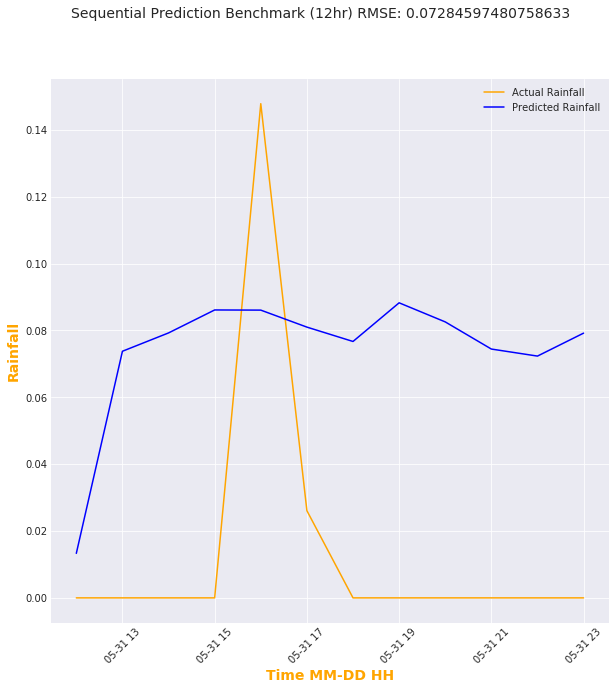

In [34]:
display_solution(predictions, lstm_data[3], normalised_data[3])